# Setting up our Schema

In [92]:

from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType

feats = []
f = open('../data/features.txt')
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)

# Creating a Dataframe

In [61]:
df = spark.read.format('csv').option('sep', '\t').schema(schema).load('./mini-sample.tdv')

# When and where was the hottest temperature observed in the dataset?

In [62]:
df.createOrReplaceTempView("TEMP_DF")
import datetime
hottest = spark.sql("SELECT MAX(temperature_surface) as maxval FROM TEMP_DF").collect()
res = df.filter(df.temperature_surface == hottest[0][0]).collect()
print('Max val observed:', hottest[0][0])
print('Timestap: ', datetime.datetime.fromtimestamp(res[0][0] / 1000).isoformat())
print('Geohash: ', res[0][1])

Max val observed: 329.73193359375
Timestap:  2015-08-26T11:00:00
Geohash:  d59eknqv867b


# Are there any Geohashes that have snow depths greater than zero for the entire year? 
List some of the top Geohashes.

In [63]:
#snow = spark.sql("select Geohash, sum(snow_cover_surface) as sum from TEMP_DF where Geohash not in (select distinct Geohash from TEMP_DF where snow_cover_surface = 0) group by Geohash order by sum desc limit 3").collect()
#for i in range(len(snow)):
#    print(snow[i])
snowDf = df.filter(df.snow_depth_surface == 0)
snowDf.createOrReplaceTempView("SNOW_DF")
geohashs = spark.sql("SELECT distinct Geohash FROM SNOW_DF group by Geohash").collect()
geohashs_set = set()
for i in range(len(geohashs)):
    geohashs_set.add(geohashs[i][0])

snow = spark.sql("select Geohash, sum(snow_depth_surface) as sum from TEMP_DF group by Geohash order by sum desc limit 100").collect()
nums = 0
for i in range(len(snow)):
    if nums == 3:
        break
    else:
        if (snow[i][0] not in geohashs_set):
            nums += 1
            print(snow[i])

Row(Geohash='c41uxkww12rz', sum=55.54595806187717)
Row(Geohash='c41ueb1jyypb', sum=49.60879868884513)
Row(Geohash='c41v48pupf00', sum=47.91927876760019)


# Where are you most likely to be struck by lightning?
Use a precision of 4 Geohash characters and provide the top 3 locations.

In [64]:
newDf = df.withColumn('Geohash', df.Geohash.substr(1, 4))
newDf.createOrReplaceTempView("NEW_TEMP_DF")
lightning = spark.sql("select Geohash, avg(lightning_surface) as avg from NEW_TEMP_DF group by Geohash order by avg desc limit 3").collect()

for i in range(len(lightning)):
    print(lightning[i])

#print(top)


Row(Geohash='9ex8', avg=0.3076923076923077)
Row(Geohash='9g0m', avg=0.30357142857142855)
Row(Geohash='9g2v', avg=0.3007518796992481)


# For this question, provide an overview of your experience with these jobs: did they complete faster? Was the programming model better or worse? Which did you prefer?

From my perspective, the biggest surprise Spark gives to me is that it provides a kind of simple, clear, SQL-style query language for us to do a lot of basic inspect on huge dateset. I think its very convenient and powerful. For project2, we need to write mappers and reducers for each question, that's a lot of codes. While for project3, we can get what we want in simplely serveral lines with the help of Spark. The most important thing is it have better performance in time(maybe also in space). Spark is harder to understand compared to MapReducer, but I prefer it.

# understand feature properties and distributions

In [69]:
from pyspark.sql.functions import avg, max, min, stddev
list = df.columns
for i in range(2, 58):
    print('Feature: ', list[i])
    res = df.select(max(df[i]), min(df[i]), avg(df[i]), stddev(df[i])).collect()
    print('Max value: ', res[0][0])
    print('Min value: ', res[0][1])
    print('Avg value: ', res[0][2])
    print('Std. Dev: ', res[0][3])
    print()

Feature:  geopotential_height_lltw
Max value:  6202.4365234375
Min value:  -8015.53125
Avg value:  2141.460589701558
Std. Dev:  1898.1221123819798

Feature:  water_equiv_of_accum_snow_depth_surface
Max value:  5649.0
Min value:  0.0
Avg value:  8.035800387291186
Std. Dev:  37.34503968059668

Feature:  drag_coefficient_surface
Max value:  48000.0
Min value:  0.0
Avg value:  0.15554024185410378
Std. Dev:  39.85484170219889

Feature:  sensible_heat_net_flux_surface
Max value:  1000000.125
Min value:  -317.9658203125
Avg value:  2460.591012176307
Std. Dev:  49251.43240969251

Feature:  categorical_ice_pellets_yes1_no0_surface
Max value:  1.0
Min value:  0.0
Avg value:  0.00030547226456155386
Std. Dev:  0.01747509678826262

Feature:  visibility_surface
Max value:  24307.435546875
Min value:  17.29292869567871
Avg value:  21715.863747615178
Std. Dev:  6142.599331655233

Feature:  number_of_soil_layers_in_root_zone_surface
Max value:  4.0
Min value:  0.0
Avg value:  1.5996940466767542
Std. De

Max value:  0.13499999046325684
Min value:  0.0
Avg value:  0.03110594852291435
Std. Dev:  0.03738048413160396



# Determine how features influence each other 
I roughly calculated the runing time if I run the code below based on the dataset NAM_2015_S, it needs about 240 hours. So I have to run it on a smaller dataset. 

Intuitively, the matrix(result) is symmetric, so for about a half of values in the matrix we just need to print something instead of calculating the "real value". We can save lots of time if we coding like this:

In [39]:
list = df.columns
for i in range(2, 58):
    for j in range(2, 58):
        #print(i)
        if (i == j):
            print(1.0, end='\t', flush=True)
        elif (i > j):
            print('x', end='\t', flush=True)
        else:
            r = df.corr(list[i], list[j])
            print(r, end='\t', flush=True)
    print()
#print(type(df.geopotential_height_lltw))
#df.corr('geopotential_height_lltw', 'water_equiv_of_accum_snow_depth_surface')

1.0	-0.46840480047580807	0.0007330140321983546	0.03125354413166816	-0.016432957091552416	0.10131729691679968	-0.21237972671186198	-0.036647624352178394	0.01771878606311824	-0.1433140221268841	-0.351507609600035	-0.18402253757179104	-0.00883363757433036	-0.07941033322886144	0.038959224620370894	0.8603489276187636	-0.18814392610806197	-0.14370165639092264	-0.04110853209833371	-0.69931198835397	0.07625728077425092	-0.4188703316550289	-0.16256114340894393	-0.06372317082624145	-0.17377748015812258	-0.188143926108062	0.15906229829143884	0.16206364164863327	0.7930170915805208	0.12651395341828875	-0.07813677513539587	0.20982974589663472	-0.140802834835867	0.045428811286286064	-0.13633239780538178	0.20934775416929408	0.8381088592170065	0.004395995764330209	0.8731233191086702	-0.7003684457588911	0.0932855256706026	0.28485850398388635	0.22106607197166003	-0.19234281504190032	-0.20191224555676401	-0.5256504418162964	0.14825931398728945	-0.6950412836689454	-0.5818548735008837	0.24203239090448408	0.

x	x	x	x	x	x	x	1.0	-0.08688208194070936	-0.0009179600788164126	0.048973840667023795	-0.008316378359596869	0.007838861204470441	0.05420819632097711	0.03738066003196773	-0.0378831343421856	0.001306437636706458	-0.007862657337698952	0.009076263173243476	0.043381677222582155	-0.0010440301781031972	0.05799685954429985	0.009631599581866266	0.003021597066157603	0.0003465670681661605	0.001306437636706458	0.00841242427040549	-0.014006063772145094	-0.004851948099456902	0.019944859516953482	-0.0065926108969273775	0.004144564848881234	0.03665842772115523	0.07650926590941479	0.0334227148591937	0.025193089882234423	-0.05956631655566353	-0.08714880116489009	-0.03422695201000977	0.05507250354036312	-0.015275584335023282	-0.016185086110509655	-0.025411836068193774	0.023581257538287957	-0.017127503040607256	0.014364671889423886	-0.019640710817449208	0.019544209940104123	-0.003795333939084782	0.04305305997396871	-0.019774003907535715	0.009438255473234921	-0.0037836440761250317	0.006474678339920395	-0.0519

x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	1.0	-0.3483594253272334	-0.23441326389841322	-0.1114420848752099	-0.7304934845499362	0.05121084787681335	-0.3841762367186776	-0.20208948870715818	0.21475828197678942	-0.33307545131500804	-0.3483594253272334	0.09252704436582533	0.04675264569613809	0.81841580616893	0.15927401222476886	-0.22246359747013053	0.09512669163662216	-0.18705977344330973	-0.10652671483587373	-0.3033782335394162	0.1558668859721425	0.8196162106218834	0.10001834763827831	0.9934482198885598	-0.7526018598684875	-0.17326541585712596	0.389912752001463	0.4707641783712597	-0.2808667660380132	-0.19004437358393794	-0.5970105097204917	0.3487955637678462	-0.727601127472816	-0.5504677322332742	0.18354091803959427	0.31018887668448997	-0.11047476996913738	-0.24896455325005598	0.6673884936972606	-0.2690638935507926	-0.24896455325005598	
x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	1.0	0.7255079484221589	-0.0491666116646789	0.4214172153749703	-0.024487149691413662	-0.21941962165625983	0.12308814257642564	-0.637895

x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	1.0	0.5954318996443404	-0.05862652693500956	-0.4427717751780733	0.06497153302654318	0.8166129775590925	0.006993839408626377	0.41216903078627704	-0.005795767255884847	0.5128797626021905	-0.22045734581943854	-0.24035864880577118	-0.01545296553678398	-0.40963653116853355	0.4045075189546629	0.6129365546762573	-0.2707326482653874	-0.28960024001573414	0.6343177145579724	0.06387231429775872	0.3362819098125284	-0.10003926447480568	0.2962444347040564	0.33697171932221304	-0.22289113794427914	-0.03543173645408778	0.04026852434340647	0.8870855276638661	-0.4103281731588352	0.24613020655028145	0.8870855276638661	
x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	1.0	0.05823708367932716	0.0029913953607738396	0.06461220600675516	0.5075228613781876	0.04102180078921807	0.18931706487717226	0.029783017609313383	0.33911436487458513	0.08905559154569286	0.08083125019143694	0.15741866644540764	0.04625637345273868	-0.06761251205578023	0.30004461877089156	-0.0

x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	1.0	-0.18560215885535614	-0.17475594775085693	0.2788350685005444	0.01273977459676384	0.12084681221333958	0.036081061766026684	0.05988785335358053	0.08283965250492238	-0.16416099189372613	-0.004471459371604317	-0.02566340651867996	0.51093239452689	-0.30518737618093605	0.16584897900712536	0.51093239452689	
x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	1.0	0.1027339717180958	-0.1391048153790131	-0.13556399610378475	-0.31369417793355087	0.06111729176018062	-0.34698284384053635	-0.12595980253655056	0.15209978671209579	0.13691112277939177	-0.06933717562710011	-0.22653724882921394	0.47303847574052715	-0.22558915854170913	-0.22653724882921392	
x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	x	1.0	-0.16884420464721706	-0.022237135603005515	-0.18818955809140073	0.5101604009923114	-0.17181361859487682	-0.18199987711228582	0.01309533118825716	0.34004

After we get the results, we copy it to a file called test.txt. We need to convert this "half matrix" to a "complete matrix". The code below is the solution to do this part of job. It also will sort all the values in the matrix in desc 
order
 
Java Code:
package edu.usfca.cs.mr.test;
import java.sql.Timestamp;
import java.text.SimpleDateFormat;
import java.util.Date;
import java.io.*;
import java.util.*;

/**
 * Created by tuo on 06/11/17.
 */
public class Test {

    protected static String getMonth(String timestamp){
       // System.out.println(timestamp);
        SimpleDateFormat t = new SimpleDateFormat("yyyy-MM-dd");
        long s = Long.parseLong(timestamp);
        return t.format(s*1000);
    }

    private static class E {
        String value;
        int x;
        int y;

        public E(String value, int x, int y){
            this.value = value;
            this.x = x;
            this.y = y;
        }
    }

    public static void main(String[] args) throws Exception {

        String[] features = {"geopotential_height_lltw",
                "water_equiv_of_accum_snow_depth_surface",
                "drag_coefficient_surface",
                "sensible_heat_net_flux_surface",
                "categorical_ice_pellets_yes1_no0_surface",
                "visibility_surface",
                "number_of_soil_layers_in_root_zone_surface",
                "categorical_freezing_rain_yes1_no0_surface",
                "pressure_reduced_to_msl_msl",
                "upward_short_wave_rad_flux_surface",
                "relative_humidity_zerodegc_isotherm",
                "categorical_snow_yes1_no0_surface",
                "u-component_of_wind_tropopause",
                "surface_wind_gust_surface",
                "total_cloud_cover_entire_atmosphere",
                "upward_long_wave_rad_flux_surface",
                "land_cover_land1_sea0_surface",
                "vegitation_type_as_in_sib_surface",
                "v-component_of_wind_pblri",
                "albedo_surface",
                "lightning_surface",
                "ice_cover_ice1_no_ice0_surface",
                "convective_inhibition_surface",
                "pressure_surface",
                "transpiration_stress-onset_soil_moisture_surface",
                "soil_porosity_surface",
                "vegetation_surface",
                "categorical_rain_yes1_no0_surface",
                "downward_long_wave_rad_flux_surface",
                "planetary_boundary_layer_height_surface",
                "soil_type_as_in_zobler_surface",
                "geopotential_height_cloud_base",
                "friction_velocity_surface",
                "maximumcomposite_radar_reflectivity_entire_atmosphere",
                "plant_canopy_surface_water_surface",
                "v-component_of_wind_maximum_wind",
                "geopotential_height_zerodegc_isotherm",
                "mean_sea_level_pressure_nam_model_reduction_msl",
                "temperature_surface",
                "snow_cover_surface",
                "geopotential_height_surface",
                "convective_available_potential_energy_surface",
                "latent_heat_net_flux_surface",
                "surface_roughness_surface",
                "pressure_maximum_wind",
                "temperature_tropopause",
                "geopotential_height_pblri",
                "pressure_tropopause",
                "snow_depth_surface",
                "v-component_of_wind_tropopause",
                "downward_short_wave_rad_flux_surface",
                "u-component_of_wind_maximum_wind",
                "wilting_point_surface",
                "precipitable_water_entire_atmosphere",
                "u-component_of_wind_pblri",
                "direct_evaporation_cease_soil_moisture_surface"};



        File input = new File("/Users/yuntuotuo/Bigdata/p2-hetuo/src/main/java/edu/usfca/cs/mr/test/test.txt");
        File output = new File ("/Users/yuntuotuo/Bigdata/p2-hetuo/src/main/java/edu/usfca/cs/mr/test/newtest.txt");
        Scanner sc = new Scanner(input);
        PrintWriter printWriter = new PrintWriter(output);
        String[][] matrix = new String[56][56];
        PriorityQueue<E> q = new PriorityQueue<>(new Comparator<E>() {
            @Override
            public int compare(E o1, E o2) {
                if (o1.value.startsWith("-"))
                    o1.value = o1.value.substring(1);
                if (o2.value.startsWith("-"))
                    o2.value = o2.value.substring(1);
                return o2.value.compareTo(o1.value);
            }
        });
        int j = 0;
        while (sc.hasNextLine()){
            String s = sc.nextLine();
            //System.out.println(s);
            String[] tokens = s.split("\\t");
            for (int i = 0; i < tokens.length; i++)
                matrix[j][i] = tokens[i];
            j++;
        }
        for (int x = 0; x < 56; x++)
            for (int y = 0; y < 56; y++)
                if (matrix[x][y].equals("x")){
                    matrix[x][y] = matrix[y][x];
                }
        for (int x = 0; x < 56; x++){
            String s = "";
            for (int y = 0; y < 55; y++){
                    s += (matrix[x][y] + '\t');
                    q.add(new E(matrix[x][y], x, y));
            }
            s += matrix[x][55];
            q.add(new E(matrix[x][55], x, 55));
            printWriter.write(s + System.lineSeparator());
            printWriter.flush();
        }

        while (!q.isEmpty()){
            E e = q.poll();
            System.out.println(features[e.x] + ", " + features[e.y] + ": " + e.value);
        }


    }
}


Next, we can use the code below to generate the heatmap

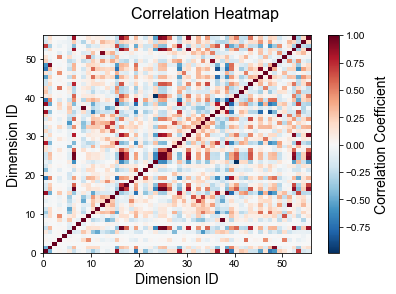

In [85]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

filename = sys.argv[1]

corr = np.loadtxt('./newtest.txt')

plt.suptitle('Correlation Heatmap', fontsize=16)
plt.xlabel('Dimension ID', fontsize=14)
plt.ylabel('Dimension ID', fontsize=14)

plt.pcolor(corr, cmap='RdBu_r')
cb = plt.colorbar()
cb.set_label('Correlation Coefficient', fontsize=14)
plt.show()

#plt.savefig(filename + '.fig.pdf', bbox_inches='tight')

# Using the feature summaries and correlations as your guide, choose a feature to predict via machine learning models in MLlib

The feature you will predict
upward_long_wave_rad_flux_surface

Features used to train the model
temperature_surface, total_cloud_cover_entire_atmosphere, geopotential_height_zerodegc_isotherm

How you partitioned your data
90% for trainning, 10% for testing

Why the model choices make sense (for example: if two features are highly correlated, then perhaps you don’t need a model…)
Because the correlation coefficient between these features are from 0.7 to 0.8

In [88]:
from pyspark.ml.feature import VectorAssembler

def prepare_data(dframe, predictors, target):
    assembler = VectorAssembler(inputCols=predictors, outputCol="features")
    output = assembler.transform(dframe)
    return output.select("features", target).withColumnRenamed(target, "label")


prepped = prepare_data(df,
    [ "temperature_surface",
        "total_cloud_cover_entire_atmosphere",
        "geopotential_height_zerodegc_isotherm"],
    "upward_long_wave_rad_flux_surface")

prepped.show()
(trainingData, testData) = prepped.randomSplit([0.9, 0.1])

+--------------------+---------+
|            features|    label|
+--------------------+---------+
|[294.092041015625...|411.65503|
|[284.776611328125...|  372.625|
|[264.309204101562...|277.01044|
|[287.61083984375,...| 387.0625|
|[299.276611328125...|    441.0|
|[247.799789428710...|214.05222|
|[301.134704589843...|452.24445|
|[285.031005859375...|374.50366|
|[281.587158203125...|345.81754|
|[300.195556640625...|447.33984|
|[297.031005859375...|428.50366|
|[279.913665771484...|336.98804|
|[288.6044921875,9...|393.20752|
|[299.527740478515...| 443.0243|
|[267.712158203125...|291.19254|
|[278.587158203125...|341.56754|
|[293.272125244140...|406.97626|
|[290.112548828125...|401.15952|
|[304.022125244140...|483.47626|
|[279.66162109375,...|336.53812|
+--------------------+---------+
only showing top 20 rows



In [89]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(numTrees=100, maxDepth=5, maxBins=32)
model = rf.fit(trainingData)
predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 16.3477


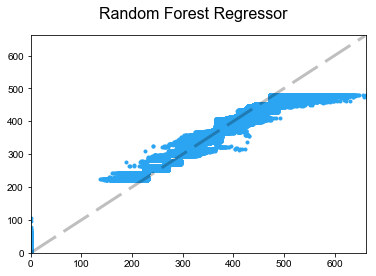

In [90]:
import matplotlib.pyplot as plt

p_df = predictions.select("label", "prediction").toPandas()

plt.suptitle('Random Forest Regressor', fontsize=16)

minval = p_df[['label', 'prediction']].min().min()
maxval = p_df[['label', 'prediction']].max().max()
plt.axis([minval, maxval, minval, maxval])

plt.plot(p_df['label'], p_df['prediction'], '.', color='#2ba5f1')
plt.plot(range(int(minval), int(maxval)), range(int(minval), int(maxval)), lw=3, dashes=(10, 3), color='#000000', alpha=0.25, label='Ideal Predictor')
plt.show()

# A visualization built from the dataset
I am going to count the total precipitation each month of 2015 in bay area.

In [51]:
from pyspark.sql.functions import sum
#Total precipitation Jan
df1 = spark.read.format('csv').option('sep', '\t').schema(schema).load('../data/nam_201501_s.tdv')
df1 = df1.withColumn('Geohash', df1.Geohash.substr(1, 3))
df1.filter(df1.Geohash == '9q9').select(sum(df1[55])).show()

#Total precipitation Feb
df2 = spark.read.format('csv').option('sep', '\t').schema(schema).load('../data/nam_201502_s.tdv')
df2 = df2.withColumn('Geohash', df2.Geohash.substr(1, 3))
df2.filter(df2.Geohash == '9q9').select(sum(df2[55])).show()

#Total precipitation Mar
df3 = spark.read.format('csv').option('sep', '\t').schema(schema).load('../data/nam_201503_s.tdv')
df3 = df3.withColumn('Geohash', df3.Geohash.substr(1, 3))
df3.filter(df3.Geohash == '9q9').select(sum(df3[55])).show()

#Total precipitation Apr
df4 = spark.read.format('csv').option('sep', '\t').schema(schema).load('../data/nam_201504_s.tdv')
df4 = df4.withColumn('Geohash', df4.Geohash.substr(1, 3))
df4.filter(df4.Geohash == '9q9').select(sum(df4[55])).show()

#Total precipition May
df5 = spark.read.format('csv').option('sep', '\t').schema(schema).load('../data/nam_201505_s.tdv')
df5 = df5.withColumn('Geohash', df5.Geohash.substr(1, 3))
df5.filter(df5.Geohash == '9q9').select(sum(df5[55])).show()

#Total precipition Jun
df6 = spark.read.format('csv').option('sep', '\t').schema(schema).load('../data/nam_201506_s.tdv')
df6 = df6.withColumn('Geohash', df6.Geohash.substr(1, 3))
df6.filter(df6.Geohash == '9q9').select(sum(df6[55])).show()

#Total precipition Jul
df7 = spark.read.format('csv').option('sep', '\t').schema(schema).load('../data/nam_201507_s.tdv')
df7 = df7.withColumn('Geohash', df7.Geohash.substr(1, 3))
df7.filter(df7.Geohash == '9q9').select(sum(df7[55])).show()

#Total precipition Aug
df8 = spark.read.format('csv').option('sep', '\t').schema(schema).load('../data/nam_201508_s.tdv')
df8 = df8.withColumn('Geohash', df8.Geohash.substr(1, 3))
df8.filter(df8.Geohash == '9q9').select(sum(df8[55])).show()

#Total precipition Sep
df9 = spark.read.format('csv').option('sep', '\t').schema(schema).load('../data/nam_201509_s.tdv')
df9 = df9.withColumn('Geohash', df9.Geohash.substr(1, 3))
df9.filter(df9.Geohash == '9q9').select(sum(df9[55])).show()

#Total precipition Oct
df10 = spark.read.format('csv').option('sep', '\t').schema(schema).load('../data/nam_201510_s.tdv')
df10 = df10.withColumn('Geohash', df10.Geohash.substr(1, 3))
df10.filter(df10.Geohash == '9q9').select(sum(df10[55])).show()

#Total precipition Nov
df11 = spark.read.format('csv').option('sep', '\t').schema(schema).load('../data/nam_201511_s.tdv')
df11 = df11.withColumn('Geohash', df11.Geohash.substr(1, 3))
df11.filter(df11.Geohash == '9q9').select(sum(df11[55])).show()

#Total precipition Dec
df12 = spark.read.format('csv').option('sep', '\t').schema(schema).load('../data/nam_201512_s.tdv')
df12 = df12.withColumn('Geohash', df12.Geohash.substr(1, 3))
df12.filter(df12.Geohash == '9q9').select(sum(df12[55])).show()


+-----------------------------------------+
|sum(precipitable_water_entire_atmosphere)|
+-----------------------------------------+
|                        61085.90829086304|
+-----------------------------------------+

+-----------------------------------------+
|sum(precipitable_water_entire_atmosphere)|
+-----------------------------------------+
|                       63169.618955135345|
+-----------------------------------------+

+-----------------------------------------+
|sum(precipitable_water_entire_atmosphere)|
+-----------------------------------------+
|                       59749.875482320786|
+-----------------------------------------+

+-----------------------------------------+
|sum(precipitable_water_entire_atmosphere)|
+-----------------------------------------+
|                       58459.129531383514|
+-----------------------------------------+

+-----------------------------------------+
|sum(precipitable_water_entire_atmosphere)|
+---------------------------

After we can the results above, we can write the results with corresponding month to a file called test.txt, then we can use the code below to read the data from test.txt and generate a histogram.

Text(0,0.5,'Precipitation (in)')

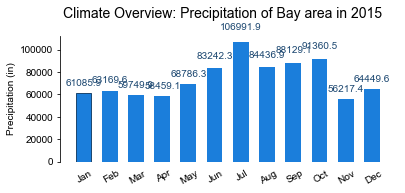

In [53]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib import rc

def disable_spines(ax):
    for s in ax.spines:
        ax.spines[s].set_visible(False)

rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

#filename = sys.argv[1]
filename = './test.txt'

with open(filename, 'r') as f:
    first_line = f.readline()[1:].strip()

data = np.loadtxt(fname=filename)
data[:, 0] = data[:, 0] - 1
data[:, 1] = data[:, 1]

plt.ion()
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(hspace=.20)
#gs = gridspec.GridSpec(2, 1, height_ratios=[1.75, 1])
gs = gridspec.GridSpec(2, 1, height_ratios=[1.75, 1])
ax1 = plt.subplot(gs[0])
plt.setp(ax1.get_xticklabels(), visible=True) # disable upper axis label

ax1.patch.set_facecolor('None')

plt.suptitle('Climate Overview: ' + first_line, fontsize=14)

rects1 = ax1.bar(.35 + data[:, 0], data[:, 1], color='#1b7edb', width=.6,
        edgecolor='#1d4871')

plt.xticks(np.arange(0,12) + .4, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    rotation=30)

disable_spines(ax1)
ax1.spines['left'].set_visible(True)

for tic in ax1.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

for tic in ax1.yaxis.get_major_ticks():
    tic.tick2On = False

for rect in rects1:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., 1.08*height,
        '%.1f' % (height), ha='center', va='bottom', color='#1d4871')
    
ax1.set_ylabel('Precipitation (in)')